In [2]:
import os
import math
import cv2
import numpy as np
from matplotlib import pyplot as plt
from sklearn.cluster import KMeans

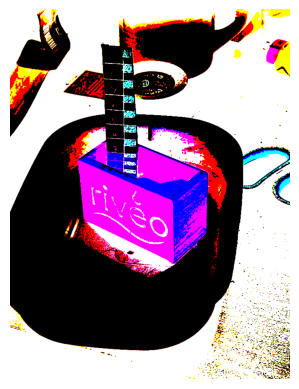

In [3]:
#Acquisition et pré-traitement

# 1. Lecture de la vidéo
#imagPath = "../../data/4/IMG_8518.png"
#imagPath = "../../data/3/3.png"
imagPath = "../../data/3/32.png"
img2 = cv2.imread(imagPath, cv2.COLOR_BGR2RGB)
img = cv2.imread(imagPath, cv2.IMREAD_GRAYSCALE)
orig = img2.copy()



_, bw = cv2.threshold(img2, 100, 255, cv2.THRESH_BINARY_INV)
#_, bw = cv2.threshold(img, 125, 190, cv2.THRESH_BINARY_INV)
plt.imshow(bw)
plt.axis("off")
plt.show()


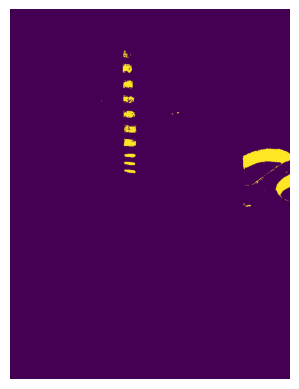

In [4]:
hsv = cv2.cvtColor(img2, cv2.COLOR_BGR2HSV)

# Définis la plage de bleu (valeurs à ajuster selon ta nuance)
lower_blue = np.array([90, 80, 20])
upper_blue = np.array([140, 255, 255])
mask = cv2.inRange(hsv, lower_blue, upper_blue)
result = cv2.bitwise_and(img2, img2, mask=mask)


plt.imshow(mask)
plt.axis("off")
plt.show()

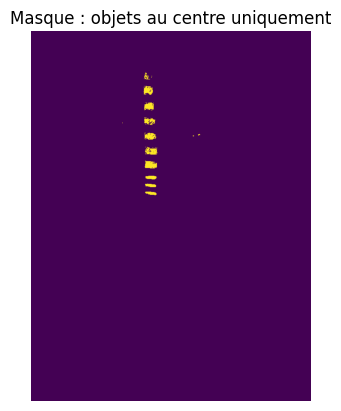

In [5]:
# -------- Garder seulement le centre --------
h, w = mask.shape
frac = 0.5  # fraction du centre à garder (0.5 = 50%)
w0 = int(w * (0.5 - frac / 2))
w1 = int(w * (0.5 + frac / 2))
h0 = int(h * (0.5 - 0.8 / 2))
h1 = int(h * (0.5 + 0.8 / 2))

center_mask = np.zeros_like(mask)
center_mask[h0:h1, w0:w1] = 255

mask_centre = cv2.bitwise_and(mask, center_mask)

plt.imshow(mask_centre)
plt.title("Masque : objets au centre uniquement")
plt.axis("off")
plt.show()

Nombre de petits carrés bleus détectés : 11
Nombre de groupes fusionnés : 11


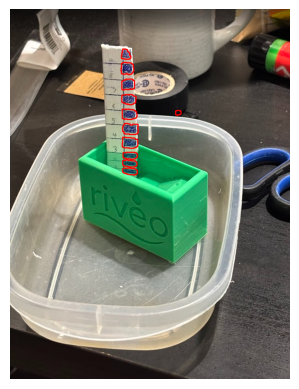

In [6]:
contours, _ = cv2.findContours(mask_centre, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

petits_bleus = [c for c in contours if 2 < cv2.contourArea(c) < 1000]  # adapte les seuils à ta taille de carrés

print(f"Nombre de petits carrés bleus détectés : {len(petits_bleus)}")


fusion = np.zeros_like(mask_centre)
cv2.drawContours(fusion, petits_bleus, -1, 255, thickness=cv2.FILLED)

kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (10, 10))  # ajuste la taille selon l'espacement réel
fusion = cv2.dilate(fusion, kernel, iterations=1)

contours_fusionnes, _ = cv2.findContours(fusion, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
print(f"Nombre de groupes fusionnés : {len(contours_fusionnes)}")


# Optionnel : visualise-les sur l'image
output = img2.copy()
cv2.drawContours(output, contours_fusionnes, -1, (0,0,255), 2)


plt.imshow(cv2.cvtColor(output, cv2.COLOR_BGR2RGB))
plt.axis("off")
plt.show()


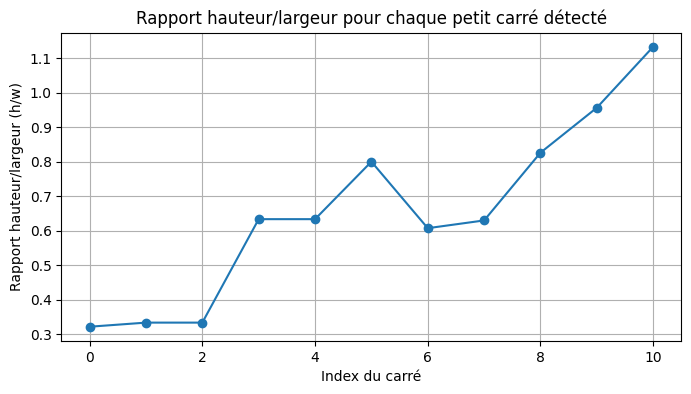

In [7]:
ratios = []
for i, cnt in enumerate(petits_bleus):
    x, y, w, h = cv2.boundingRect(cnt)
    if h != 0:  # Pour éviter la division par zéro
        ratio = h / w
    else:
        ratio = 0
    ratios.append(ratio)

# Tracer le rapport hauteur/largeur
plt.figure(figsize=(8, 4))
plt.plot(range(len(ratios)), ratios, marker='o')
plt.xlabel("Index du carré")
plt.ylabel("Rapport hauteur/largeur (h/w)")
plt.title("Rapport hauteur/largeur pour chaque petit carré détecté")
plt.grid(True)
plt.show()

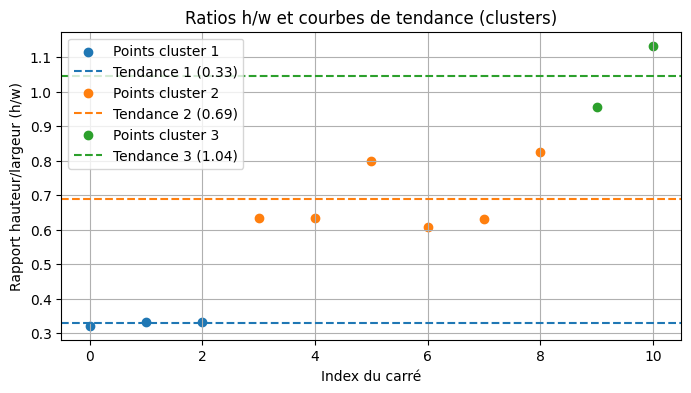

In [8]:
ratios = np.array(ratios).reshape(-1, 1)
n_clusters = 3  # Mets 2 ou 3 selon ton besoin

kmeans = KMeans(n_clusters=n_clusters, n_init=10, random_state=0)
labels = kmeans.fit_predict(ratios)

# Couleurs différentes pour chaque groupe (prend la palette tab10 pour être sûr)
colors = plt.get_cmap('tab10').colors

plt.figure(figsize=(8, 4))
for k in range(n_clusters):
    cluster_indices = np.where(labels == k)[0]
    plt.scatter(cluster_indices, ratios[labels == k], color=colors[k], label=f'Points cluster {k+1}')
    mean_k = np.mean(ratios[labels == k])
    plt.axhline(mean_k, color=colors[k], linestyle='--', label=f'Tendance {k+1} ({mean_k:.2f})')

plt.xlabel("Index du carré")
plt.ylabel("Rapport hauteur/largeur (h/w)")
plt.title("Ratios h/w et courbes de tendance (clusters)")
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
nb_premier_cluster = np.sum(labels == 0)
print(f"Nombre de points qui sont dans le premier cluster : {nb_premier_cluster}")


print(f"La règle est immerger de  : {nb_premier_cluster * 1} cm")

Nombre de points qui ne sont pas dans le dernier cluster : 3
La règle est immerger de  : 7 cm
